# Sentiment Anlaysis
## An Introduction
### What is it?
Natural Language Processing (NLP): A sub-discipline of computer science, artificial intelligence and linguistics that builds computational models to process and understand natural language. Examples include language translation, auto-correct, language generation, topic summarization, sentiment analysis, and many more.  

Sentiment Analysis (Opinion Mining): Identification of opinions/emotions (positive, negative and neutral) within text data.  It can be used to identify public sentiment towards certain words or topics and gauge the attitude/sentiment using analytical processing of the textual data.

In this notebook, we'll look at some Twitter data, learn how to convert to numerical features, and develop a basic Sentiment Analysis model to categorize a the tone of a tweet.  In the process, we will uncover some issues with text data, discuss cleaning and ways of converting to features, and use a pre-trained model.  By the end of this lecture, you should have an understanding of sentiment analysis, how it is used, and ways of creating such a model.


#### Who Uses?
Businesses today depend on data, period.  Whether from online Yelp reviews, customer survey, social media, chats, or emails, much of this data is unstructured text, which is difficult to use en mass. Added to this difficulty include abbreviated text (slang, short forms, memes and emoticons).  But it's important to have the ability to summarize and understand trends even in this unstructured data.  

* Companies track negative/positive sentiment in response to advertising on social media
* Aggregated free-form text from online surveys
* Identify rising trends (popular songs, foods, brands)


#### Further Reading
* https://www.kaggle.com/kazanova/sentiment140
* https://www.wonderflow.co/blog/sentiment-analysis-examples
* https://www.nltk.org/data.html
* https://medium.com/@randerson112358/stock-market-sentiment-analysis-using-python-machine-learning-5b644f151a3e
* https://regex101.com/
* https://algotrading101.com/learn/sentiment-analysis-python-guide/
* https://www.kdnuggets.com/2016/06/politics-analytics-trump-clinton-sanders-twitter-sentiment.html
* https://amiham-singh.github.io/
* https://icwsm.org/papers/3--Godbole-Srinivasaiah-Skiena.pdf
* https://scikit-learn.org/stable/modules/feature_extraction.html

# Example

In [8]:
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, twitter_samples
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from wordcloud import WordCloud

%matplotlib inline
nltk.download('twitter_samples')
nltk.download('stopwords')
nltk.download('vader_lexicon')

## Getting the Data

In [9]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

From the NLTK package, 5k positive and negative tweets are sampled (labeled by emoticons).  We will use these for our model building and analysis.  What does a positive tweet look like?

In [10]:
print('Positive Tweets:')
for i in range(6):
    print(str(i) + ': ' +positive_tweets[i])

Positive Tweets:
0: #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
1: @Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!
2: @DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!
3: @97sides CONGRATS :)
4: yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days
5: @BhaktisBanter @PallaviRuhail This one is irresistible :)
#FlipkartFashionFriday http://t.co/EbZ0L2VENM


And negative?

In [11]:
print('Negative Tweets:')
for i in range(6):
    print(str(i) + ': ' +negative_tweets[i])

Negative Tweets:
0: hopeless for tmr :(
1: Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(
2: @Hegelbon That heart sliding into the waste basket. :(
3: “@ketchBurning: I hate Japanese call him "bani" :( :(”

Me too
4: Dang starting next week I have "work" :(
5: oh god, my babies' faces :( https://t.co/9fcwGvaki0


## Pretrained model

As part of the NLTK package, there is a already trained sentiment analysis model called VADER (Valence Aware Dictionary for Sentiment Reasoning).  We will consider this a "black-box" type model to understand how sentiment analysis can be used (but without going into the specifics of this type of model).  To load and use, call "SentimentIntensityAnalyzer" with the following:

In [10]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(negative_tweets[0])

{'neg': 0.747, 'neu': 0.253, 'pos': 0.0, 'compound': -0.7096}

In [11]:
#sid.polarity_scores('the food is good.')
#sid.polarity_scores('the food is good!')
#sid.polarity_scores('the food is GOOD!')

## Creating Text Features

In [13]:
df = pd.DataFrame(positive_tweets)
df = df.append(negative_tweets,0)
df.columns = ['text']
df['sentiment'] = [1]*len(positive_tweets)+[0]*len(negative_tweets)

In [14]:
df.shape

(10000, 2)

Before we build a model, consider some tweets and issues the text could have on our outcomes:

In [15]:
print(positive_tweets[0])
print(negative_tweets[0])
print(negative_tweets[16])
print(negative_tweets[11])

#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
hopeless for tmr :(
@aysegul_k pleasse :(
@Rampageinthebox mare ivan :(


Possible steps in cleaning text: 
* Remove Punctuation
* Remove numbers/symbols
* Remove Links/URLs/usernames/hashtags
* Remove case-senstivity
* Stop Words
* Whitespace
* Misspellings


## Cleaning data 

In [24]:
df.text.iloc[0]

'@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!'

In [28]:
df['text_clean'] = df.text.str.replace('[@#][^\s]+','').str.replace('[.!?:\)\(]','').str.lower().str.strip()

In [47]:
df.text_clean.iloc[0]

'for being top engaged members in my community this week'

## Featurize

The basic method of featurizing text is to convert a collection of text documents to a matrix of word counts, also known as "bag-of-words".

In [34]:
df.text_clean.iloc[0:5]

0    for being top engaged members in my community ...
1    hey james how odd / please call our contact ce...
2    we had a listen last night  as you bleed is an...
3                                             congrats
4    yeaaaah yippppy  my accnt verified rqst has su...
Name: text_clean, dtype: object

In [49]:
vectorizer = CountVectorizer()#stop_words=stopwords.words('english'), max_features=800)
bow = vectorizer.fit_transform(df.text_clean).toarray()

In [50]:
bow[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [51]:
np.where(bow[0]==1)

(array([135, 433, 688, 748]),)

In [52]:
np.array(vectorizer.get_feature_names())[np.where(bow[0]==1)[0]]

array(['community', 'members', 'top', 'week'], dtype='<U15')

## And Finally, A Model

In [54]:

X_train, X_test, y_train, y_test = train_test_split(bow, df.sentiment, test_size=0.2, random_state=0)

In [55]:
model = LogisticRegression()
model.fit(X_train, y_train)

print ("Accuracy (test data):" , model.score(X_test, y_test))

Accuracy (test data): 0.7525


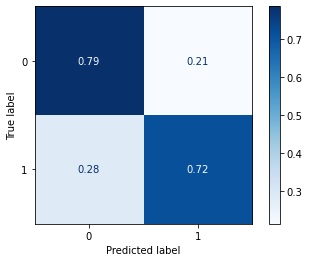

In [60]:
plot_confusion_matrix(model, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

In [61]:
df_coeffs = pd.DataFrame(model.coef_, columns=vectorizer.get_feature_names()).transpose()
df_coeffs.columns = ['coeff_value']

In [62]:
df_coeffs.sort_values('coeff_value',inplace=True)

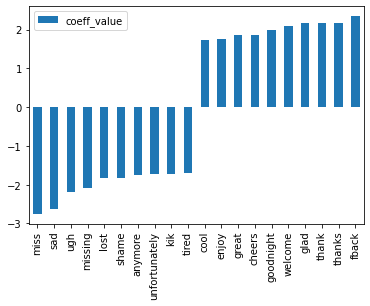

In [63]:
df_top_bot = df_coeffs.iloc[0:10,:].append(df_coeffs.iloc[-10:,:])
df_top_bot.plot(kind='bar')


## For Next Time
For Next Time
Consider refining our model, here are a few options to try:
* In CountVectorizer, try playing with the parameters max_df=1.0, min_df=1, max_features=None (see sklearn documentation https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* Try using TfidfVectorizer instead (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)
* Try using other classifier inplace of LogisticRegressor
* For data cleaning, try removing repeated character with a regular expession (such as "yipeeeeeee" and "yayyyyyyy") and/or urls
* Consider lemmatizer/stemming words (see for example https://www.geeksforgeeks.org/python-lemmatization-with-nltk/)


